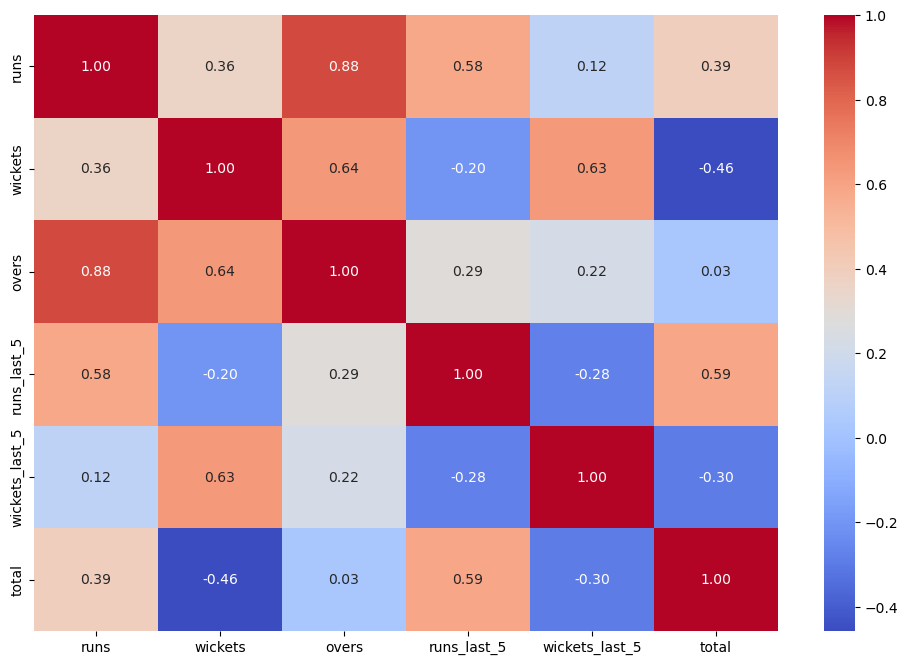

(37330, 19)
(2778, 19)


In [3]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv(r'C:\Users\hp\Desktop\Python Excercise\Assesment\ipl.csv')

data['date'] = pd.to_datetime(data['date'], errors='coerce')

data.drop(columns=[
    'mid', 'venue', 'batsman', 'bowler',
    'striker', 'non-striker'
], inplace=True)

consistent_teams = [
    'Chennai Super Kings',
    'Delhi Daredevils',
    'Kings XI Punjab',
    'Kolkata Knight Riders',
    'Mumbai Indians',
    'Rajasthan Royals',
    'Royal Challengers Bangalore',
    'Sunrisers Hyderabad'
]

data = data[
    data['bat_team'].isin(consistent_teams) &
    data['bowl_team'].isin(consistent_teams)
]

data = data[data['overs'] >= 5.0]

numeric_features = data.select_dtypes(include=np.number)

plt.figure(figsize=(12, 8))
sns.heatmap(numeric_features.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

encoded_data = pd.get_dummies(
    data,
    columns=['bat_team', 'bowl_team'],
    drop_first=True
)

encoded_data['year'] = encoded_data['date'].dt.year

train_data = encoded_data[encoded_data['year'] <= 2016]
test_data = encoded_data[encoded_data['year'] == 2017]

X_train = train_data.drop(['total', 'date', 'year'], axis=1)
y_train = train_data['total']

X_test = test_data.drop(['total', 'date', 'year'], axis=1)
y_test = test_data['total']

print(X_train.shape)
print(X_test.shape)


In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "AdaBoost": AdaBoostRegressor(
        estimator=LinearRegression(),
        n_estimators=50,
        random_state=42
    )
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    results.append([name, mae, mse, rmse])

results_df = pd.DataFrame(
    results,
    columns=["Model", "MAE", "MSE", "RMSE"]
)

print(results_df.sort_values("RMSE"))


               Model        MAE         MSE       RMSE
3           AdaBoost  12.080601  244.795093  15.645929
0  Linear Regression  12.118618  251.007923  15.843230
2      Random Forest  13.865142  335.385201  18.313525
1      Decision Tree  16.364651  501.224982  22.388054


In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
linear_pred = linear_model.predict(X_test)

linear_mae = mean_absolute_error(y_test, linear_pred)
linear_mse = mean_squared_error(y_test, linear_pred)
linear_rmse = np.sqrt(linear_mse)

adaboost_model = AdaBoostRegressor(
    estimator=LinearRegression(),
    n_estimators=100,
    random_state=42
)

adaboost_model.fit(X_train, y_train)
adaboost_pred = adaboost_model.predict(X_test)

adaboost_mae = mean_absolute_error(y_test, adaboost_pred)
adaboost_mse = mean_squared_error(y_test, adaboost_pred)
adaboost_rmse = np.sqrt(adaboost_mse)

comparison = pd.DataFrame({
    "Model": ["Linear Regression", "AdaBoost (Linear Regression)"],
    "MAE": [linear_mae, adaboost_mae],
    "MSE": [linear_mse, adaboost_mse],
    "RMSE": [linear_rmse, adaboost_rmse]
})

print(comparison)


                          Model        MAE         MSE       RMSE
0             Linear Regression  12.118618  251.007923  15.843230
1  AdaBoost (Linear Regression)  12.080601  244.795093  15.645929


In [6]:
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np

final_model = LinearRegression()
final_model.fit(X_train, y_train)

def predict_score(
    batting_team,
    bowling_team,
    overs,
    runs,
    wickets,
    runs_last_5,
    wickets_last_5
):
    input_dict = {
        'overs': overs,
        'runs': runs,
        'wickets': wickets,
        'runs_last_5': runs_last_5,
        'wickets_last_5': wickets_last_5
    }

    for col in X_train.columns:
        if col.startswith('bat_team_'):
            input_dict[col] = 1 if col == f'bat_team_{batting_team}' else 0
        if col.startswith('bowl_team_'):
            input_dict[col] = 1 if col == f'bowl_team_{bowling_team}' else 0

    input_df = pd.DataFrame([input_dict])
    input_df = input_df.reindex(columns=X_train.columns, fill_value=0)

    prediction = final_model.predict(input_df)[0]
    return int(round(prediction))

pred1 = predict_score(
    batting_team='Kolkata Knight Riders',
    bowling_team='Delhi Daredevils',
    overs=15.2,
    runs=140,
    wickets=4,
    runs_last_5=52,
    wickets_last_5=2
)

pred2 = predict_score(
    batting_team='Sunrisers Hyderabad',
    bowling_team='Royal Challengers Bangalore',
    overs=16.1,
    runs=118,
    wickets=6,
    runs_last_5=36,
    wickets_last_5=3
)

pred3 = predict_score(
    batting_team='Mumbai Indians',
    bowling_team='Kings XI Punjab',
    overs=17.4,
    runs=160,
    wickets=5,
    runs_last_5=58,
    wickets_last_5=2
)

pred4 = predict_score(
    batting_team='Rajasthan Royals',
    bowling_team='Chennai Super Kings',
    overs=16.0,
    runs=120,
    wickets=4,
    runs_last_5=40,
    wickets_last_5=1
)

predictions = pd.DataFrame({
    "Match": [
        "KKR vs DD (2018)",
        "SRH vs RCB (2018)",
        "MI vs KXIP (2019)",
        "RR vs CSK (2019)"
    ],
    "Predicted Score": [
        f"{pred1}/9",
        f"{pred2}/10",
        f"{pred3}/8",
        f"{pred4}/7"
    ]
})

print(predictions)


               Match Predicted Score
0   KKR vs DD (2018)           179/9
1  SRH vs RCB (2018)          145/10
2  MI vs KXIP (2019)           186/8
3   RR vs CSK (2019)           154/7
